In [1]:
! ls

README.md		    quick_start_images
data			    snow_height_anomaly-Copy1.keras
quick_start_advanced.ipynb  snow_height_anomaly.keras
quick_start_beginner.ipynb


In [1]:
import random

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [2]:
SEQ_SIZE = 20 
EPOCHS = 50
TRAIN_SIZE = 3
VALIDATION_PERCENTAGE = 0.3
BATCH_SIZE = 64
SHUFFLE_SEQS = False
SCALE = True


In [4]:
def merge_into_one():
    path = '../data/labeled_daily'
    files = os.listdir(path)

    pd.concat(pd.read_csv(f'{path}/{s}') for s in files).to_csv('merged.csv')
    
merge_into_one()    

In [27]:
def resample_and_save(read_path='../data/labeled', save_path='../data/labeled_daily'):
    files = os.listdir(read_path)

    for s in files:
        station = pd.read_csv(f'{read_path}/{s}')
        station['station_code'] = s[:-4]
        
        station = preprocess(station, resample='D')
        
        station.to_csv(f'{save_path}/{s}')

In [28]:
def load_stations(path, count, shuffle = False):
    files = os.listdir(path)
    
    if shuffle:
        random.shuffle(files)
    else:
        files = sorted(files)
    
    dataframes = []
    for s in files[:count]:
        if not s.endswith('csv'):
            continue
        station = pd.read_csv(f'{path}/{s}')
        station['station_code'] = s[:-4]
        dataframes.append(station)

    return pd.concat(dataframes, ignore_index=True), files[:count], files[count:]

In [29]:
def load_station(path, station_name, resample=None):
    df = pd.read_csv(f'{path}/{station_name}')
    df['station_code'] = station_name[:-4]
    
    if resample is not None:
        df = resample(df, resample) 

    return df

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def preprocess(df, scale=False, resample=None):
    data = df[['station_code', 'measure_date', 'HS', 'no_snow', 'anomaly']].copy()
    data['measure_date'] = pd.to_datetime(data['measure_date']).dt.tz_localize(None)
    data.dropna(inplace=True)

    if scale:
        # def scale_group(group):
        #     scaler = StandardScaler()
        #     # TODO: Could try standardizing and then scaling
        #     group['HS'] = scaler.fit_transform(group[['HS']])
        #     return group

        # data = data.groupby('station_code').apply(scale_group).reset_index(drop=True)
        data['HS'] = MinMaxScaler().fit_transform(data[['HS']])

    if resample:
        data.set_index('measure_date', inplace=True)
        data = data.groupby('station_code').resample(resample).agg({
            'HS': lambda x: x.iloc[np.argmax(np.abs(x.values - x.mean()))],
            'no_snow': lambda x: x.value_counts().idxmax(), # TODO: Could try x.any() to improve predictions?
            'anomaly': lambda x: x.any()
        }).reset_index()

    return data

In [31]:
def split_stations_into_seqs(df, y, target, seq_size, shuffle = False):
    all_seqs = []

    for name, station in df.groupby('station_code'):
        y_values = station[y].values
        target_values = station[target].values

        num_sequences = len(y_values) - seq_size

        sequences_array = np.empty((num_sequences, 2), dtype=object)

        for i in range(num_sequences):
            sequences_array[i, 0] = y_values[i: i + seq_size]
            sequences_array[i, 1] = target_values[i + seq_size - 1]

        all_seqs.extend(sequences_array)

    all_seqs = np.array(all_seqs)

    if shuffle:
        np.random.shuffle(all_seqs)
    
    return np.stack(np.array(all_seqs[:, 0])), np.stack(np.array(all_seqs[:, 1]))

In [32]:
def create_train_validation_split(sequences, percentage=0.2):
    total_len = len(sequences[1])
    validation_len = int(percentage * total_len)
    
    train_X = sequences[0][0:total_len - validation_len]
    train_y = sequences[1][0:total_len - validation_len]
    
    val_X = sequences[0][total_len - validation_len:]
    val_y = sequences[1][total_len - validation_len:]
    
    return train_X, train_y, val_X, val_y

In [33]:
def plot_data(dfs, y='HS', target='no_snow', predictions=None):
    if not isinstance(dfs, list):
        dfs = [dfs]
        
    if not isinstance(predictions, list):
        predictions = [predictions] if predictions else []

    if not isinstance(y, list):
        y = [y] * len(dfs)

    if not isinstance(target, list):
        target = [target] * len(dfs)

    if len(predictions):
        rows = len(dfs) * 2
    else:
        rows = len(dfs)

    fig, axes = plt.subplots(rows, 1, figsize=(20, 5 * rows))
    
    if not isinstance(axes, np.ndarray):
        axes = [axes] 

    for i, df in enumerate(dfs):
        plot_df = df.copy()
        plot_df.index = pd.to_datetime(plot_df['measure_date'])
        station_code = plot_df['station_code'].iloc[0]
        
        # Plot original data
        ax = axes[2 * i] if len(predictions) else axes[i]
        ax.set_xlabel('Date')
        ax.set_ylabel(y[i])
        ax.set_title(f'Station: {station_code} | Original Data with Anomalies Highlighted')
        ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
        ax.scatter(plot_df[plot_df[target[i]]].index, plot_df[plot_df[target[i]]][y[i]], color='red', label='Anomalies', zorder=5, s=20)
        ax.legend()

        # Plot predictions
        if len(predictions):
            ax = axes[2 * i + 1]
            ax.set_xlabel('Date')
            ax.set_ylabel(y[i])
            ax.set_title(f'Station: {station_code} | Predicted Data with Anomalies Highlighted')
            ax.plot(plot_df.index, plot_df[y[i]], label='Data', marker='o', linestyle='-', ms=4)
            ax.scatter(plot_df[predictions[i]].index, plot_df[predictions[i]][y[i]], color='green', label='Predicted Anomalies', zorder=5, s=20)
            ax.legend()

    plt.tight_layout()
    plt.show()

def plot_keras_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [34]:
! ls data/labeled_daily

AMD2.csv  FLU2.csv  GLA2.csv  KLO2.csv	RNZ2.csv  SPN2.csv  TUM2.csv
ARO3.csv  FNH2.csv  GUT2.csv  KLO3.csv	SHE2.csv  STN2.csv  WFJ2.csv
BOR2.csv  FOU2.csv  ILI2.csv  LAG3.csv	SLF2.csv  TRU2.csv


In [35]:
stations_df, train_station_names, test_station_names  = load_stations('./data/labeled_daily', TRAIN_SIZE)

In [36]:
preprocessed_stations_df = preprocess(stations_df, scale=SCALE)

In [37]:
sequences = split_stations_into_seqs(preprocessed_stations_df, 'HS', 'no_snow', seq_size=SEQ_SIZE, shuffle=SHUFFLE_SEQS)

train_X, train_y, val_X, val_y = create_train_validation_split(sequences, percentage=VALIDATION_PERCENTAGE)

In [38]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((13193, 20), (13193,), (5654, 20), (5654,))

In [39]:
from datetime import datetime
from keras.layers import CuDNNLSTM, BatchNormalization, Dropout, TimeDistributed, GlobalMaxPooling1D
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from datetime import datetime


current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f"{current_time}_epochs-{EPOCHS}_seq-{SEQ_SIZE}_train-{TRAIN_SIZE}_test-{VALIDATION_PERCENTAGE}_shuffle-seqs-{SHUFFLE_SEQS}_scale-{SCALE}"
log_dir = f"../logs/{model_name}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

train_X = np.reshape(train_X, (-1, SEQ_SIZE, 1))
# val_X = np.reshape(val_X, (-1, SEQ_SIZE, 1))

model = Sequential()
model.add(CuDNNLSTM(128, input_shape=train_X.shape[1:], return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128, input_shape=train_X.shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss='binary_crossentropy',
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, weight_decay=1e-6),
    metrics=['accuracy']
)
hist = model.fit(
    x=train_X,
    y=train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
207/207 [==============================] - 3s 9ms/step - loss: 0.2313 - accuracy: 0.9087 - val_loss: 0.8143 - val_accuracy: 0.6176
Epoch 2/50
207/207 [==============================] - 2s 8ms/step - loss: 0.2024 - accuracy: 0.9212 - val_loss: 2.3440 - val_accuracy: 0.6176
Epoch 3/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1894 - accuracy: 0.9266 - val_loss: 1.4813 - val_accuracy: 0.6176
Epoch 4/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1862 - accuracy: 0.9269 - val_loss: 0.4722 - val_accuracy: 0.6265
Epoch 5/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1799 - accuracy: 0.9301 - val_loss: 1.2334 - val_accuracy: 0.6173
Epoch 6/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1792 - accuracy: 0.9320 - val_loss: 0.4011 - val_accuracy: 0.7282
Epoch 7/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1767 - accuracy: 0.9319 - val_loss: 0.6338 - val_accuracy: 0.8475
Epoch 

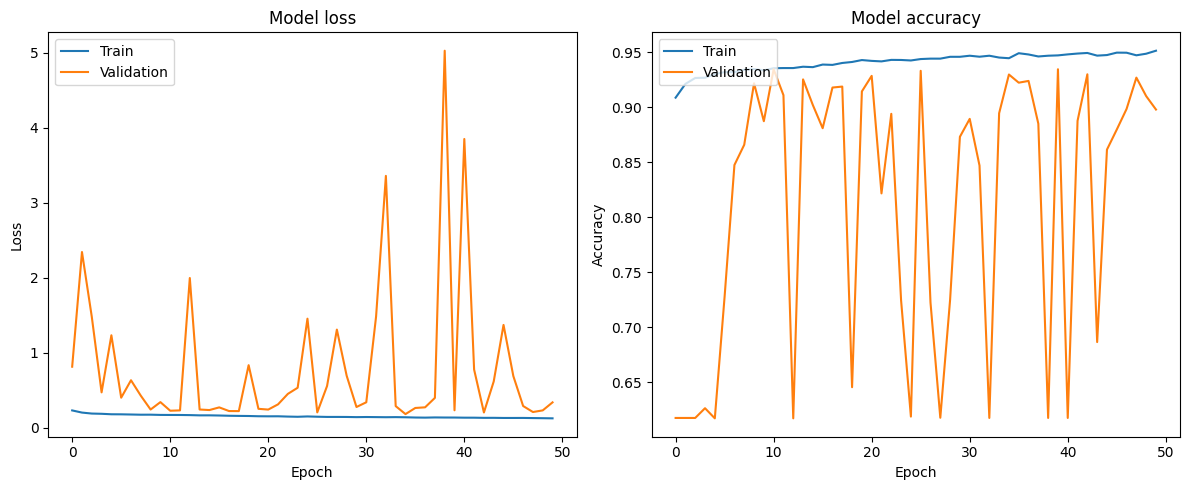

In [40]:
plot_keras_history(hist)

In [41]:
test_dfs = [preprocess(load_station("./data/labeled_daily", st)) for st in test_station_names if not st.startswith(".ipynb")]

In [52]:
for df in test_dfs:
    model.evaluate(df['HS'], df['no_snow'])


244/244 [==============================] - 1s 3ms/step - loss: 0.7309 - accuracy: 0.3493


In [42]:
preds = []
accs = []

for test in test_dfs:
    predictions = model.predict(test['HS'])
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    correct_predictions = np.sum(predicted_labels == test['no_snow'].values.flatten())
    accuracy = correct_predictions / len(test)
    print(f"Station: {test.iloc[0]['station_code']}, Accuracy: {accuracy}")
    
    accs.append(accuracy)
    preds.append(predictions > 0.5)
    
print(f"Avg accuracy: {sum(accs) / len(test_dfs)}")

# plot_data(test_dfs, predictions=preds)  
    

245/245 [==============================] - 1s 2ms/step
Station: BOR2, Accuracy: 0.7407170294494239
221/221 [==============================] - 0s 1ms/step
Station: FLU2, Accuracy: 0.7537851988113768
290/290 [==============================] - 0s 2ms/step
Station: FNH2, Accuracy: 0.6850673854447439
267/267 [==============================] - 0s 2ms/step
Station: FOU2, Accuracy: 0.8869075551384327
255/255 [==============================] - 0s 1ms/step
Station: GLA2, Accuracy: 0.6248923871602509
266/266 [==============================] - 0s 1ms/step
Station: GUT2, Accuracy: 0.6474947071277346
262/262 [==============================] - 0s 2ms/step
Station: ILI2, Accuracy: 0.6065279770444764
300/300 [==============================] - 0s 2ms/step
Station: KLO2, Accuracy: 0.6727083333333334
300/300 [==============================] - 0s 2ms/step
Station: KLO3, Accuracy: 0.7517219787100814
151/151 [==============================] - 0s 1ms/step
Station: LAG3, Accuracy: 0.7122153209109731
163/163 [=

In [453]:
((model.predict(test_dfs[0]['HS'][100:150]).reshape(-1) > 0.5) == test_dfs[0]['HS'][100:150]).value_counts()

2/2 [==============================] - 0s 3ms/step


HS
False    50
Name: count, dtype: int64